In [1]:
from qiskit import QuantumCircuit
from Functions.helpers import *
from Functions.Key_Generate import *
from Functions.Arithmetics import *
from Functions.Subnibble import *
SAES_GATE_LOG = []
key = []

In [2]:
plaintext = '1001011011001111'   # 16 bits
round_key = '1010011100111011'   # 16 bits (if needed)

total_qubits = 68
qc = QuantumCircuit(total_qubits)

# Generate Round Keys for all Stages 
K = generate_round_keys(round_key)

# place plaintext on 0..15
apply_plaintext(qc,
                plaintext)
log_gate_stats("Apply plaintext",
               qc,
               SAES_GATE_LOG)

# Add round key to Plain text 
add_round_key(qc,
              K[0])

log_gate_stats("Add RoundKey 0",
               qc,
               SAES_GATE_LOG)

# Subnibble 1
apply_subnibbles_round(
    qc,
    state_base=0,
    workspace_base=32,
    output_base=52
)
log_gate_stats("SubNibble 1",
               qc,
               SAES_GATE_LOG)

[LOG] Recorded stage 'Apply plaintext'  → total gates = 10, depth = 1
[LOG] Recorded stage 'Add RoundKey 0'  → total gates = 36, depth = 2
[LOG] Recorded stage 'SubNibble 1'  → total gates = 420, depth = 151


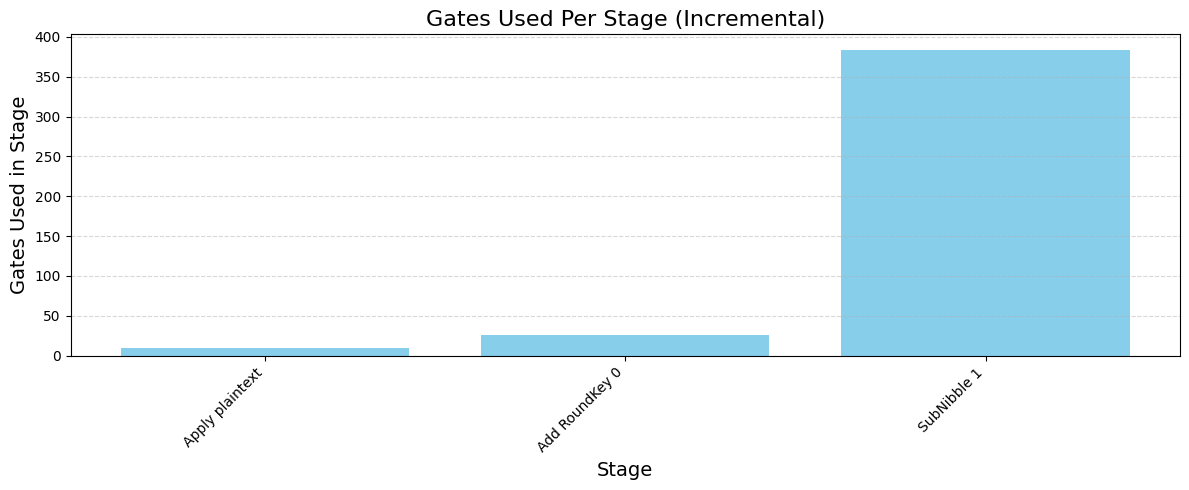

[10, 26, 384]


In [3]:
import matplotlib.pyplot as plt

def plot_gate_usage_per_stage(log):
    """
    Given SAES_GATE_LOG, compute (current - previous)
    and plot a bar chart of gates *used in each stage*.
    """

    stages = [entry['stage'] for entry in log]
    totals  = [entry['total_gates'] for entry in log]

    # Compute per-stage usage
    per_stage = []
    for i in range(len(totals)):
        if i == 0:
            per_stage.append(totals[i])  # first stage
        else:
            per_stage.append(totals[i] - totals[i-1])

    # Bar chart
    plt.figure(figsize=(12, 5))
    plt.bar(stages, per_stage, color='skyblue')

    plt.xticks(rotation=45, ha='right')
    plt.title("Gates Used Per Stage (Incremental)", fontsize=16)
    plt.xlabel("Stage", fontsize=14)
    plt.ylabel("Gates Used in Stage", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return per_stage


per_stage_gates = plot_gate_usage_per_stage(SAES_GATE_LOG)
print(per_stage_gates)